# Beirut damage propagated in NetConf
This notebook aims to get Beirut damage data associated with satellite imagery and run belief propagation on the data using NetConf

In [103]:
# Installs 
#%pip install rioxarray xarray earthpy

# Package imports
import math
import json
import requests
import os
import ipyleaflet
import PIL
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as ro
import rioxarray as rxr
import xarray as xr
import earthpy as et
import earthpy.plot as ep
import matplotlib.pyplot as plt
from base64 import b64encode
from io import BytesIO
from tqdm import tqdm
from ipywidgets import HTML
from ipyleaflet import Map, basemaps, GeoData, CircleMarker, Popup, GeoJSON, LegendControl, ImageOverlay
from rasterio.plot import show
from IPython.display import Image, display
from shapely.geometry import Polygon, Point, mapping

import descarteslabs as dl
import descarteslabs.workflows as wf

import netconf.netconf as nc

In [4]:
# Define variables
# Location variables
lat, lon, zoom = 33.8975, 35.5063, 14 # Map properties

# Building Footprints variables
buildings = "./data/beirutBuildingFootprints.geojson"

# Damage Assessment variables
dataFile = "./data/geopalData.csv" # GeoPal data

# Interferogram paths
ifgPath = "./data/20200730_20200805_IW1_Stack_ifg_deb_dinsar_flt_ML_TC_big.tif"
croppedPath = "./data/croppedIfg.tif"

# A priori damage beliefs (green, yellow, red decisions)
gb, yb, rb = 0.1, 0.7, 0.95
ratioWeight = 1

_____________
## 1 - Import Ground Datasets

In [6]:
# Import footprints geojson
# Display header 
builds = gpd.read_file(buildings)
pd.set_option('display.max_columns', None)
fps = gpd.GeoDataFrame(builds[['id','building','name']], geometry=builds.geometry)
fps.head()

,id,building,name,geometry
0,relation/71853,yes,None,"POLYGON ((35.4894536 33.8946995, 35.4894132 33..."
1,relation/6678216,residential,None,"POLYGON ((35.524633 33.8898401, 35.5246194 33...."
2,relation/6996546,school,Collège des Trois Docteurs,"POLYGON ((35.5185524 33.8949802, 35.5185834 33..."
3,relation/7000797,school,كلية القلب الأقدس,"(POLYGON ((35.5106324 33.895221, 35.5106476 33..."
4,relation/7026674,yes,None,"POLYGON ((35.5053153 33.893788, 35.5048335 33...."


In [7]:
# Import GeoPal data
allData = pd.read_csv(dataFile)
# Extract locations from joint column in database
locations, mapPoints = allData['get location - الموقع_w_2049198'], allData['point on map - الموقع على الخريطة_w_2049199']
lats, lons = np.zeros([len(locations), 1]),  np.zeros([len(locations), 1])
for i in range(len(locations)):
    loc = locations[i]
    if type(loc) is float or (type(loc) is str and loc[0].isalpha()):
        mp = mapPoints[i]
        if type(mp) is str and mp[0].isdigit():
            try: lats[i], lons[i] = mp.split(' ')[0], mp.split(' ')[1]
            except: lats[i], lons[i] = mp.split(',')[0], mp.split(',')[1] # Deal with rogue commas instead of space
    else: lats[i], lons[i] = loc.split(' ')[0], loc.split(' ')[1]

# Extract columns of useful data
data = pd.DataFrame({
    'id': allData['Job ID'],
    'area': allData['plot area - المنطقة العقارية_w_2049201'],
    'damage': allData['structural damage level - مستوى الضرر الأنشائي للمبنى_w_2049205'],
    'floors': allData['number of floors - عدد الطوابق_w_2049208'],
    'units': allData['number of units - عدد الشقق_w_2049209'],
    'use': allData['building use - وجهة الاستعمال للمبنى_w_2049210'],
    'photos': allData['take pictures - التقاط صور_w_2049222'],
    'decision': allData['decision - القرار_w_2049224']    
})

# Create geodatabase merging locations with useful data
assessments = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(lons, lats),crs={'init': 'epsg:4326'})

# Filter for non located values
locs = assessments[assessments.geometry.x != 0]
locs.head()

,id,area,damage,floors,units,use,photos,decision,geometry
0,278,El Bachoura الباشورة,NaN,NaN,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,NaN,POINT (35.5577379 33.8830089)
2,280,Achrafieh الأشرفية,NaN,NaN,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,NaN,POINT (35.557755 33.8830024)
3,281,Achrafieh الأشرفية,Partially destroyed (poses a public safety haz...,5.0,5.0,"Residential سكني,Commercial تجاري",NaN,NaN,POINT (35.5577587 33.8830063)
5,283,Achrafieh الأشرفية,Partially destroyed (poses a public safety haz...,4.0,5.0,"Residential سكني,Commercial تجاري",https://app.geopalsolutions.com/jobs/viewworkf...,YELLOW (restricted use) أصفر (لا يصلح للسكن),POINT (35.5577435 33.8830157)
6,284,Achrafieh الأشرفية,Partially destroyed (poses a public safety haz...,4.0,8.0,"Residential سكني,Commercial تجاري",https://app.geopalsolutions.com/jobs/viewworkf...,YELLOW (restricted use) أصفر (لا يصلح للسكن),POINT (35.5577312 33.8829998)


____________
## 2 - Combine building footprints with damage assessments

In [8]:
# Get joint geodataframe of building footprints with damage assessments
joint = gpd.sjoin(fps, locs, how="left", op='contains').dropna(subset=['decision'])
joint.head()

,id_left,building,name,geometry,index_right,id_right,area,damage,floors,units,use,photos,decision
1,relation/6678216,residential,None,"POLYGON ((35.524633 33.8898401, 35.5246194 33....",1111.0,2108,Achrafieh الأشرفية,Not affected - غير متأذي,3.0,NaN,Residential سكني,https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)
19,relation/7460523,yes,العاملية,"(POLYGON ((35.5059967 33.8827747, 35.5056111 3...",5630.0,10808,El Mazraa المزرعة,Not affected - غير متأذي,5.0,4.0,"Commercial تجاري, Residential سكني",https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)
24,relation/7803503,yes,None,"POLYGON ((35.4971487 33.8855667, 35.4971174 33...",5520.0,10670,El Msaytbeh المصيطبة,Not affected - غير متأذي,7.0,NaN,NaN,https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)
24,relation/7803503,yes,None,"POLYGON ((35.4971487 33.8855667, 35.4971174 33...",5505.0,10652,El Msaytbeh المصيطبة,Not affected - غير متأذي,8.0,NaN,Residential سكني,https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)
27,relation/8056967,yes,None,"POLYGON ((35.5222517 33.8889111, 35.5217716 33...",811.0,1300,Achrafieh الأشرفية,Not affected - غير متأذي,2.0,NaN,Residential سكني,https://app.geopalsolutions.com/jobs/viewworkf...,GREEN (inspected) أخضر (تم دراسته)


In [9]:
def to_geodata(gdf, color):
    plotGdf = GeoData(geo_dataframe = gdf,
                          style={'color': color, 'radius':2, 'fillColor': color, 'opacity':0.9, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.7},
                          hover_style={'fillColor': 'white' , 'fillOpacity': 0.2},
                          point_style={'radius': 3, 'color': color, 'fillOpacity': 0.8, 'fillColor': color, 'weight': 3},
                          name = 'Images')
    return plotGdf

In [10]:
m1 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom, scroll_wheel_zoom=True)
m1.add_layer(to_geodata(joint.loc[joint['decision'] == 'GREEN (inspected) أخضر (تم دراسته)'],'green'))
m1.add_layer(to_geodata(joint.loc[joint['decision'] == 'YELLOW (restricted use) أصفر (لا يصلح للسكن)'],'yellow'))
m1.add_layer(to_geodata(joint.loc[joint['decision'] == 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء'],'red'))

if not 'l1' in globals(): # Add legend if forming map for first time
    l1 = legend = LegendControl({"No Restrictions":"#008000", "Restricted Use":"#FFFF00", "Unsafe/Evacuated":"#FF0000", "No Decision":"#0000FF"}, name="Decision", position="bottomleft")
    m1.add_control(l1)
m1

Map(center=[33.8975, 35.5063], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [11]:
# Display map upon which to draw Polygon for analysis
r = 0.01
testPoly = ipyleaflet.Polygon(locations=[(lat-r, lon-r), (lat-r, lon+r), (lat+r, lon+r),(lat+r, lon-r)], color="yellow", fill_color="yellow", transform=True)

m1.add_layer(testPoly)

____________
## 3 - Pixel values from interferogram

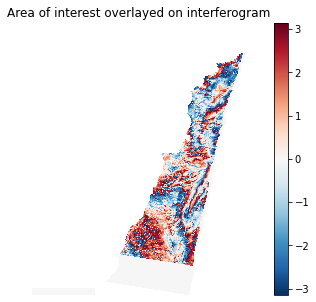

In [45]:
# Import interferogram
wholeIfg = rxr.open_rasterio(ifgPath, masked=True).squeeze()

# Define AOI
poly = Polygon([[p['lng'], p['lat']] for p in testPoly.locations[0]])

# Plot AOI on whole interferogram
f, ax = plt.subplots(figsize=(10, 5))
wholeIfg.plot.imshow(ax=ax)
extent = gpd.GeoSeries([poly])
extent.plot(ax=ax, alpha=.8, color = 'yellow')
ax.set(title="Area of interest overlayed on interferogram")
ax.set_axis_off()
plt.show()

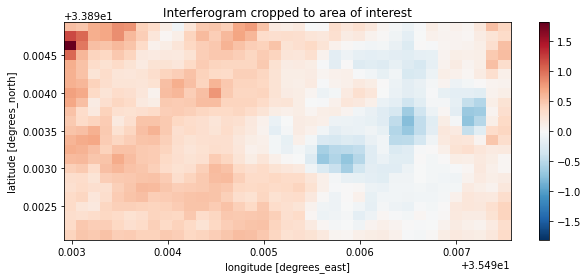

Map(center=[33.8975, 35.5063], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [107]:
# Plot cropped interferogram
croppedIfg = wholeIfg.rio.clip(extent.geometry.apply(mapping), extent.crs)

f, ax = plt.subplots(figsize=(10, 4))
croppedIfg.plot(ax=ax)
ax.set(title="Interferogram cropped to area of interest")
plt.show()

# Plot interferogram on basemap
def image_overlay(url, bounds, name):
    """Overlays an image from the Internet or locally on the map.
    Args:
        url (str): http URL or local file path to the image.
        bounds (tuple): bounding box of the image in the format of (lower_left(lat, lon), upper_right(lat, lon)), such as ((13, -130), (32, -100)).
        name (str): name of the layer to show on the layer control.
    """
    if not url.startswith('http'):
        ext, image, f = os.path.splitext(url)[1][1:], PIL.Image.open(url), BytesIO()  # file extension
        image.save(f, ext)
        data = b64encode(f.getvalue()).decode('ascii')
        url = 'data:image/{};base64,'.format(ext) + data
        
    return ImageOverlay(url=url, bounds=bounds, name=name)

m2 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[lat, lon], zoom=zoom+1, scroll_wheel_zoom=True)
PIL.Image.fromarray((croppedIfg.data*255).astype('uint8')).convert('RGB').save('./data/cropped.png')
bounds = (min(np.array(croppedIfg.y)), min(np.array(croppedIfg.x))), (max(np.array(croppedIfg.y)), max(np.array(croppedIfg.x)))
image = image_overlay(url='./data/cropped.png', bounds=bounds, name = 'Interferogram')
ifl = m2.add_layer(image)
m2

________________
## 4 - Associate damage belief with pixels as nodes

In [47]:
named = croppedIfg.rename('ifg')
df = named.to_dataframe()
coords = np.concatenate(np.array(df.axes[0]))
initial = gpd.GeoDataFrame(pd.DataFrame(np.concatenate((np.ones([len(df),2])*0.5, np.array(df['ifg']).reshape(-1,1)), axis=1), columns = ['noDmg','dmg','ifg']), geometry=gpd.points_from_xy(coords[1::2], coords[0::2]),crs={'init': 'epsg:4326'})

In [48]:
# Assign updated beliefs to pixels within assessed building footprints
nodes = gpd.sjoin(initial, joint[['geometry','decision']], how='left', op='within')
nodes = nodes[~nodes.index.duplicated(keep='first')]
nodes.loc[nodes.decision == 'GREEN (inspected) أخضر (تم دراسته)', ['noDmg', 'dmg']] = 1-gb, gb
nodes.loc[nodes.decision == 'YELLOW (restricted use) أصفر (لا يصلح للسكن)', ['noDmg', 'dmg']] = 1-yb, yb
nodes.loc[nodes.decision == 'RED (unsafe/evacuate) أحمر (غير آمن/للاخلاء)ء', ['noDmg', 'dmg']] = 1-rb, rb
nodes.head()

,noDmg,dmg,ifg,geometry,index_right,decision
0,0.5,0.5,0.543900,POINT (35.4929841598192 33.89487559014123),NaN,NaN
1,0.5,0.5,0.497914,POINT (35.49310965446439 33.89487559014123),NaN,NaN
2,0.5,0.5,0.649612,POINT (35.49323514910958 33.89487559014123),NaN,NaN
3,0.5,0.5,0.704774,POINT (35.49336064375477 33.89487559014123),NaN,NaN
4,0.5,0.5,0.833239,POINT (35.49348613839997 33.89487559014123),NaN,NaN


In [49]:
# Show example of green decision nodes
nodes.loc[nodes.decision == 'GREEN (inspected) أخضر (تم دراسته)']

,noDmg,dmg,ifg,geometry,index_right,decision
51,0.9,0.1,0.705952,POINT (35.49474108485188 33.89475009549604),11773.0,GREEN (inspected) أخضر (تم دراسته)
108,0.9,0.1,0.115271,POINT (35.49725097775571 33.89462460085085),1687.0,GREEN (inspected) أخضر (تم دراسته)
145,0.9,0.1,0.120061,POINT (35.49725097775571 33.89449910620566),1687.0,GREEN (inspected) أخضر (تم دراسته)
277,0.9,0.1,0.151529,POINT (35.49524306343265 33.89399712762489),11724.0,GREEN (inspected) أخضر (تم دراسته)
279,0.9,0.1,0.050381,POINT (35.49549405272302 33.89399712762489),7983.0,GREEN (inspected) أخضر (تم دراسته)
316,0.9,0.1,-0.001275,POINT (35.49549405272302 33.8938716329797),7983.0,GREEN (inspected) أخضر (تم دراسته)
325,0.9,0.1,-0.207282,POINT (35.49662350452975 33.8938716329797),7990.0,GREEN (inspected) أخضر (تم دراسته)
326,0.9,0.1,-0.037754,POINT (35.49674899917494 33.8938716329797),7990.0,GREEN (inspected) أخضر (تم دراسته)
344,0.9,0.1,0.384521,POINT (35.49436460091631 33.89374613833451),7415.0,GREEN (inspected) أخضر (تم دراسته)
345,0.9,0.1,0.358767,POINT (35.4944900955615 33.89374613833451),7415.0,GREEN (inspected) أخضر (تم دراسته)


_______________
## 5 - Create edges

In [62]:
adjacent = True
ifgValues = True

In [63]:
edges = []
# Create edges between geographically adjacent nodes
if adjacent:
    x, l = len(df), len(nodes)
    for i in nodes.index:
        if not i % x == x-1: edges.append([i,i+1]) # Pixel to right (edge to left is equivalent to previous edge to right)
        if not i > l-x-1: edges.append([i,i+x]) # Pixel below (edge above is accounted for is equivalent to previous edge below)

# Create edges between most similar phase change pixels
if ifgValues:
    srt = nodes.sort_values(['ifg'])
    for i in range(len(srt.index)-1):
        edges.append([srt.index[i],srt.index[i+1]])

____________
## 6 - Run NetConf for belief propagation

Text(0.5, 1.0, 'A priori damage probability')

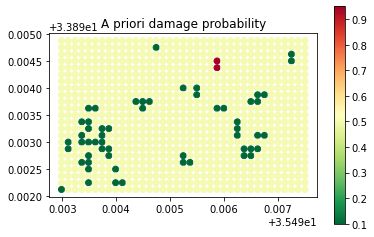

In [64]:
# Map for beliefs prior
prePlot = nodes.plot(column='dmg', cmap='RdYlGn_r', legend=True)
prePlot.set_title('A priori damage probability')

In [65]:
priors = np.array(nodes[['noDmg','dmg']])
beliefs, _ = nc.netconf(np.array(edges),priors,verbose=True)
if not os.path.exists('./results'): os.mkdir('results')
np.savetxt('results/BeirutBeliefs.csv', beliefs, delimiter=",", fmt='%s')
print('Output written results/BeirutBeliefs.csv\n')

It	max{del(B)}	del(label)

0	3.75475e-01		10

1	1.39723e-01		20

2	6.08933e-02		27

3	2.52520e-02		10

4	1.11326e-02		2

5	4.83066e-03		4

6	2.16959e-03		1

7	9.60313e-04		1

8	4.33273e-04		1

9	1.92699e-04		1

10	8.74998e-05		0

Output written results/BeirutBeliefs.csv



Text(0.5, 1.0, 'Updated damage likelihood')

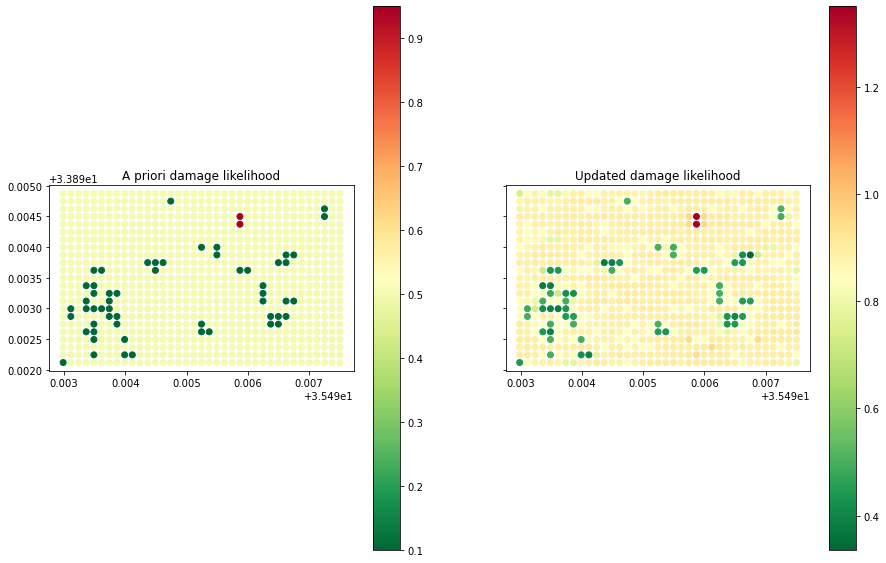

In [66]:
fig, (ax1, ax2) = plt.subplots(figsize=(15,10), ncols=2, sharex=True, sharey=True)
prePlot = nodes.plot(ax=ax1, column='dmg', cmap='RdYlGn_r', legend=True)
postPlot = nodes.plot(ax=ax2, column=beliefs[:,1], cmap='RdYlGn_r', legend=True)
prePlot.set_title('A priori damage likelihood')
postPlot.set_title('Updated damage likelihood')

___________
## Run for multiple edge types at once

In [97]:
# For multiple runs for different edge options
m = 0
for edgeTypes in ([True, False], [False, True], [True, True]):
    globals()['edges'+str(m)] = []
    adjacent, ifgValues = edgeTypes
    # Create edges between geographically adjacent nodes
    if adjacent:
        x, l = len(df), len(nodes)
        for i in nodes.index:
            if not i % x == x-1: globals()['edges'+str(m)].append([i,i+1]) # Pixel to right (edge to left is equivalent to previous edge to right)
            if not i > l-x-1: globals()['edges'+str(m)].append([i,i+x]) # Pixel below (edge above is accounted for is equivalent to previous edge below)

    # Create edges between most similar phase change pixels
    if ifgValues:
        srt = nodes.sort_values(['ifg'])
        dist = 2
        for i in range(len(srt.index)-dist):
            for j in range(dist-1):
                globals()['edges'+str(m)].append([srt.index[i],srt.index[i+1+j]])
            
    m+=1

In [98]:
# For multiple edge types
priors = np.array(nodes[['noDmg','dmg']])
for m in range(3): 
    globals()['beliefs'+str(m)], _ = nc.netconf(np.array(globals()['edges'+str(m)]),priors)

18  iterations
18  iterations
11  iterations


Text(0.5, 1.0, 'Combination edges posterior')

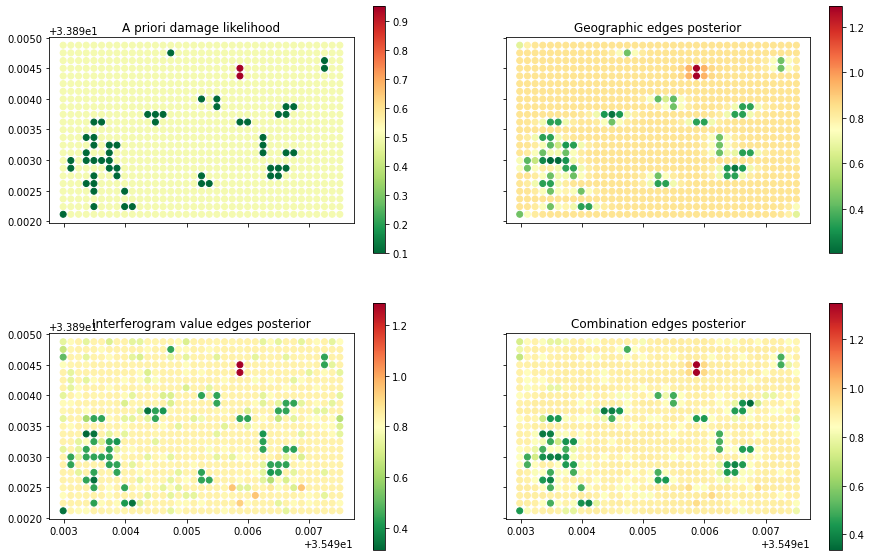

In [99]:
# For multiple edge types
fig, axs = plt.subplots(2, 2, figsize=(15,10), sharex=True, sharey=True)
prePlot = nodes.plot(ax=axs[0,0], column='dmg', cmap='RdYlGn_r', legend=True)
postPlot = nodes.plot(ax=axs[0,1], column=beliefs0[:,1], cmap='RdYlGn_r', legend=True)
ifgPlot = nodes.plot(ax=axs[1,0], column=beliefs1[:,1], cmap='RdYlGn_r', legend=True)
comboPlot = nodes.plot(ax=axs[1,1], column=beliefs2[:,1], cmap='RdYlGn_r', legend=True)
prePlot.set_title('A priori damage likelihood')
postPlot.set_title('Geographic edges posterior')
ifgPlot.set_title('Interferogram value edges posterior')
comboPlot.set_title('Combination edges posterior')